In [16]:
import numpy as np
from qiskit.circuit import Gate, QuantumCircuit, Parameter
from qiskit.circuit.library import RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, CXGate, SwapGate, RZZGate
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate, Parameter
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit.library import (
    RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, 
    CXGate, SwapGate, RZZGate, PauliEvolutionGate
)
from qiskit.quantum_info import SparsePauliOp, Statevector, Pauli, Operator
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler.passes import BasisTranslator
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper
from qiskit_nature.units import DistanceUnit
from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate, MSGate, ZZGate
from qiskit.circuit.library import (
    RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, 
    CXGate, SwapGate, RZZGate, PauliEvolutionGate
)


n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383


# 修改 main_loop 增加 diff_threshold 参数
def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)  # 如果电路里没有这个门，默认 count=0
        fidelity *= (1 - error_rate) ** count
        #print(f"Gate: {gate}, Count: {count}, Error: {error_rate}, Contribution: {(1 - error_rate) ** count:.6f}")
    fidelity *= readout_fidelity
    return fidelity

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

basis_gates = ["gpi", "gpi2", "zz"]

gate_error = {
    "gpi": 2e-4,      # 1-qubit
    "gpi2": 2e-4,      # 1-qubit    
    "zz": 5.1e-3,      # 1-qubit
}


coupling_map = CouplingMap.from_full(4)



# Print out for checking
print("Gate median errors (percentage):")
for gate, error in gate_error.items():
    print(f"{gate}: {error}%")


# 生成 diff_to_target 阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)
fidelity_list = []

total_count_list = []  # 存储每个 precision 下的 gate 总数
for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    beta_list, energy_list, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates,
        coupling_map=coupling_map,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()
    total_count = sum(gate_counts.values())  # 所有 gate 总数
    total_count_list.append(total_count)
    for gate, count in transpiled_circuit.count_ops().items():
        print(f"Gate: {gate}, Count: {count}")


    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    print(f"Threshold: {threshold:.6f}, Expected Fidelity: {expected_fidelity:.6f}, Total Gates: {total_count}")

    if fidelity_list[-1] < 0.0001:
        print("Expected fidelity reached zero, exiting loop early.")
        break

import matplotlib.pyplot as plt

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Main title for the entire figure
fig.suptitle('Heron Processor Topo2', fontsize=16, fontweight='bold')

# Plot 1: Precision vs Expected Fidelity
ax1.plot(precision_list[:len(fidelity_list)], fidelity_list, marker='o', label='Expected Fidelity (blue)', color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)')
ax1.set_ylabel('Expected Fidelity')
ax1.set_title('Precision vs Expected Fidelity')
ax1.grid(True)
ax1.legend()

# Plot 2: Precision vs Total Basis Count
ax2.plot(precision_list[:len(total_count_list)], total_count_list, marker='o', color='orange', label='Total Basis Count (orange)')
ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)')
ax2.set_ylabel('Total Basis Count')
ax2.set_title('Precision vs Total Basis Count')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

Gate median errors (percentage):
gpi: 0.0002%
gpi2: 0.0002%
zz: 0.0051%


TranspilerError: "Unable to translate the operations in the circuit: ['rzz', 'sdg', 'h', 'cx', 's', 'rz', 'rx'] to the backend's (or manually specified) target basis: ['while_loop', 'store', 'zz', 'reset', 'for_loop', 'delay', 'gpi', 'measure', 'barrier', 'switch_case', 'gpi2', 'snapshot', 'if_else']. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.BasisTranslator#translation-errors"

Testing single FALQON layer for Heron, Eagle, and Ion Trap Processors...

Testing Heron Processor

Testing Heron Topo1...
  Expected Fidelity: 0.904675
  Total Gate Count: 156
  Energy: -0.767453

Testing Heron Topo2...
  Expected Fidelity: 0.865394
  Total Gate Count: 210
  Energy: -0.767453

Testing Heron Topo3...
  Expected Fidelity: 0.919083
  Total Gate Count: 128
  Energy: -0.767453

Testing Heron Topo4...
  Expected Fidelity: 0.925232
  Total Gate Count: 127
  Energy: -0.767453

Testing Heron Topo5...
  Expected Fidelity: 0.925232
  Total Gate Count: 127
  Energy: -0.767453

Testing Eagle Processor

Testing Eagle Topo1...
  Expected Fidelity: 0.742181
  Total Gate Count: 228
  Energy: -0.767453

Testing Eagle Topo2...
  Expected Fidelity: 0.664809
  Total Gate Count: 296
  Energy: -0.767453

Testing Eagle Topo3...
  Expected Fidelity: 0.769866
  Total Gate Count: 208
  Energy: -0.767453

Testing Eagle Topo4...
  Expected Fidelity: 0.784004
  Total Gate Count: 197
  Energy: -0.76

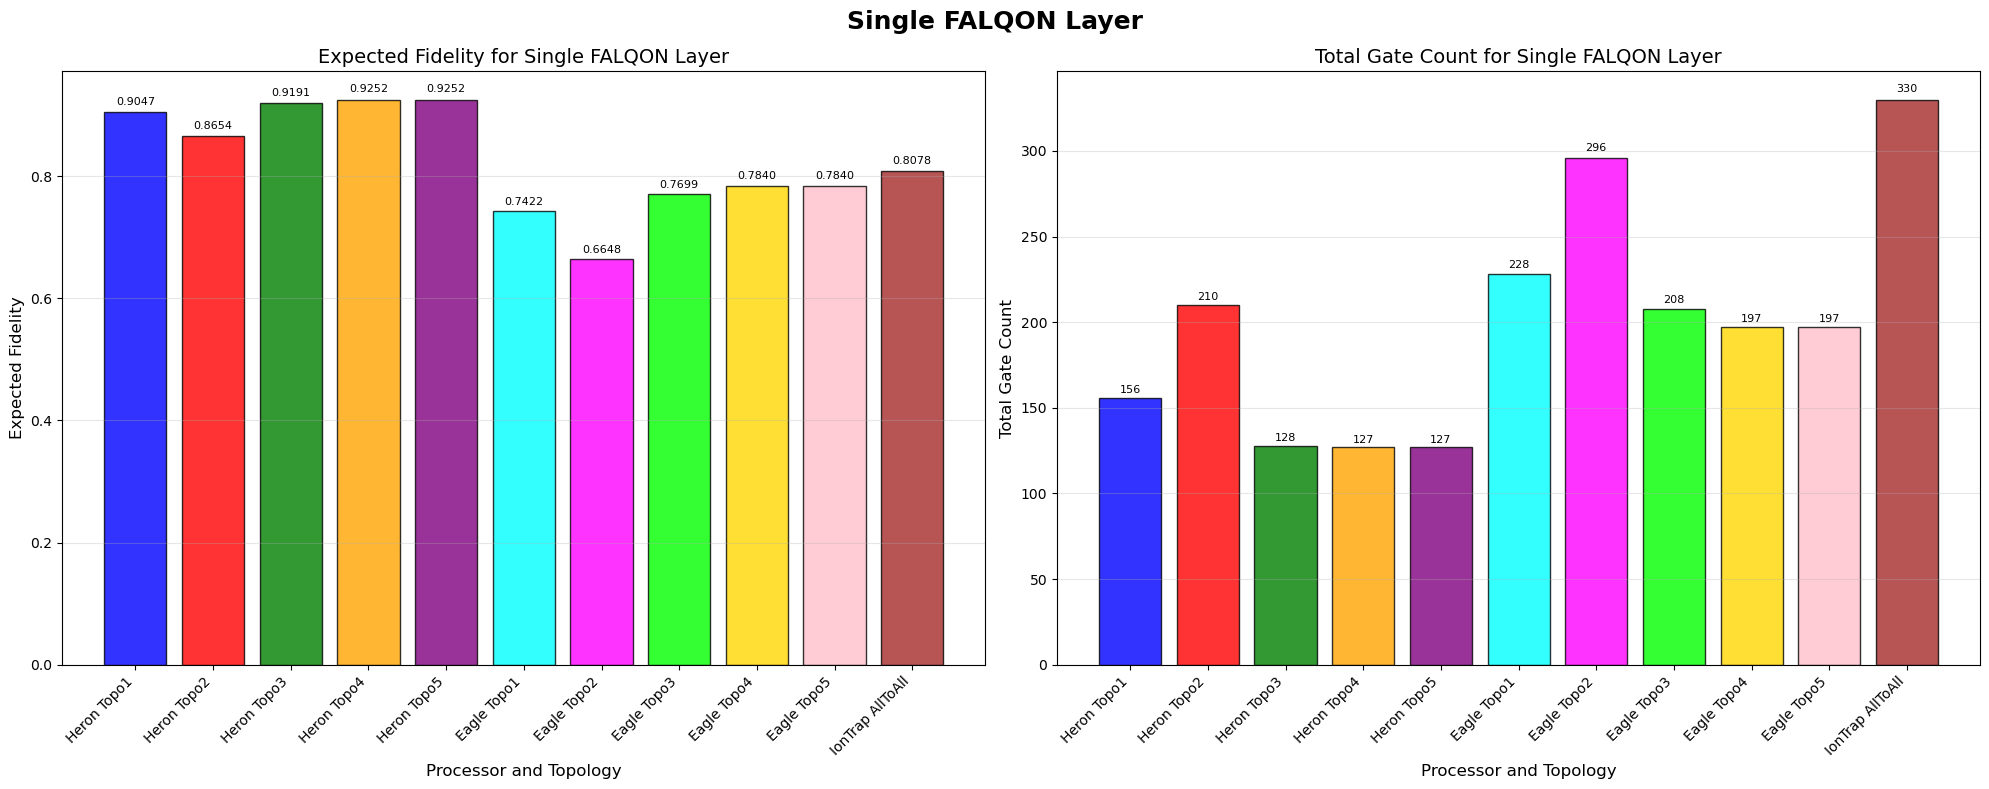


SINGLE FALQON LAYER - DETAILED RESULTS
Processor-Topology   Fidelity     Gate Count   Energy       Next Beta   
--------------------------------------------------------------------------------
Heron Topo1          0.904675     156          -0.767453    0.013478    
Heron Topo2          0.865394     210          -0.767453    0.013478    
Heron Topo3          0.919083     128          -0.767453    0.013478    
Heron Topo4          0.925232     127          -0.767453    0.013478    
Heron Topo5          0.925232     127          -0.767453    0.013478    
Eagle Topo1          0.742181     228          -0.767453    0.013478    
Eagle Topo2          0.664809     296          -0.767453    0.013478    
Eagle Topo3          0.769866     208          -0.767453    0.013478    
Eagle Topo4          0.784004     197          -0.767453    0.013478    
Eagle Topo5          0.784004     197          -0.767453    0.013478    
IonTrap AllToAll     0.807835     330          -0.767453    0.013478    

PE

In [ ]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np

# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def single_falqon_step(qc, cost_h, driver_h, comm_h, delta_t, beta_0):
    """运行单个FALQON步骤"""
    state = Statevector.from_label("+" * n_qubits)
    
    # 单个FALQON层
    qc_layer = QuantumCircuit(n_qubits)
    falqon_layer(qc_layer, cost_h, driver_h, beta_0, delta_t)
    qc.compose(qc_layer, inplace=True)
    state = state.evolve(qc_layer)
    
    # 计算能量和下一个beta
    energy = state.expectation_value(cost_h).real
    next_beta = -1 * state.expectation_value(comm_h).real
    
    return qc, energy, next_beta

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
beta_0 = 0.0
delta_t = 0.03

# 处理器配置
processors = {
    "Heron": {
        "basis_gates": ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'],
        "gate_error": {
            "id": 2.738e-4,
            "rx": 2.738e-4,
            "rz": 0.0,
            "sx": 2.738e-4,
            "x": 2.738e-4,
            "cz": 1.947e-3,
            "rzz": 2.490e-3
        }
    },
    "Eagle": {
        "basis_gates": ['ecr', 'id', 'rz', 'sx', 'x'],
        "gate_error": {
            "ecr": 5.824e-3,      
            "id": 2.252e-4,      
            "rz": 0.0,           
            "sx": 2.252e-4,      
            "x": 2.252e-4,       
        }
    },
    "IonTrap": {
        "basis_gates": ["gpi", "gpi2", "zz"],
        "gate_error": {
            "gpi": 2e-4,
            "gpi2": 2e-4,
            "zz": 5.1e-3,
        }
    }
}

# 定义不同的拓扑结构
topologies = {
    "Topo1": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# Ion Trap 专用全连接拓扑
ion_trap_topology = {
    "AllToAll": CouplingMap.from_full(4)  # 全连接拓扑
}

# 存储所有结果
all_results = {}
labels = []

print("Testing single FALQON layer for Heron, Eagle, and Ion Trap Processors...")

# 对Heron和Eagle处理器的每个拓扑运行实验
for processor_name, processor_config in processors.items():
    if processor_name == "IonTrap":  # 跳过IonTrap，单独处理
        continue
        
    print(f"\n{'='*50}")
    print(f"Testing {processor_name} Processor")
    print(f"{'='*50}")
    
    basis_gates = processor_config["basis_gates"]
    gate_error = processor_config["gate_error"]
    
    for topo_name, coupling_list in topologies.items():
        combined_name = f"{processor_name} {topo_name}"
        labels.append(combined_name)
        print(f"\nTesting {combined_name}...")
        
        coupling_map = CouplingMap(couplinglist=coupling_list)
        
        # 初始化电路
        qc_initial = uniform_superposition_circuit()
        
        # 运行单个FALQON步骤
        final_circuit, energy, next_beta = single_falqon_step(
            qc=qc_initial,
            cost_h=cost_h,
            driver_h=driver_h,
            comm_h=comm_h,
            delta_t=delta_t,
            beta_0=beta_0
        )

        # Transpile 电路
        transpiled_circuit = transpile(
            final_circuit,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            optimization_level=1
        )

        # 统计 gate count
        gate_counts = transpiled_circuit.count_ops()
        total_count = sum(gate_counts.values())

        # 计算 expected fidelity
        expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
        
        # 存储结果
        all_results[combined_name] = {
            'fidelity': expected_fidelity,
            'gate_count': total_count,
            'energy': energy,
            'next_beta': next_beta,
            'processor': processor_name,
            'topology': topo_name
        }
        
        print(f"  Expected Fidelity: {expected_fidelity:.6f}")
        print(f"  Total Gate Count: {total_count}")
        print(f"  Energy: {energy:.6f}")

# 单独处理Ion Trap (All-to-All拓扑)
print(f"\n{'='*50}")
print(f"Testing IonTrap Processor")
print(f"{'='*50}")

processor_config = processors["IonTrap"]
basis_gates = processor_config["basis_gates"]
gate_error = processor_config["gate_error"]

combined_name = "IonTrap AllToAll"
labels.append(combined_name)
print(f"\nTesting {combined_name}...")

coupling_map = ion_trap_topology["AllToAll"]

# 初始化电路
qc_initial = uniform_superposition_circuit()

# 运行单个FALQON步骤
final_circuit, energy, next_beta = single_falqon_step(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0
)

# Transpile 电路
transpiled_circuit = transpile(
    final_circuit,
    basis_gates=basis_gates,
    coupling_map=coupling_map,
    optimization_level=1
)

# 统计 gate count
gate_counts = transpiled_circuit.count_ops()
total_count = sum(gate_counts.values())

# 计算 expected fidelity
expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)

# 存储结果
all_results[combined_name] = {
    'fidelity': expected_fidelity,
    'gate_count': total_count,
    'energy': energy,
    'next_beta': next_beta,
    'processor': "IonTrap",
    'topology': "AllToAll"
}

print(f"  Expected Fidelity: {expected_fidelity:.6f}")
print(f"  Total Gate Count: {total_count}")
print(f"  Energy: {energy:.6f}")

# 准备绘图数据
fidelities = [all_results[label]['fidelity'] for label in labels]
gate_counts = [all_results[label]['gate_count'] for label in labels]

# 定义颜色 - 11种不同颜色
colors = ['blue', 'red', 'green', 'orange', 'purple', 
          'cyan', 'magenta', 'lime', 'gold', 'pink', 'brown']

# 创建柱状图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Single FALQON Layer', fontsize=18, fontweight='bold')

# 柱状图1: Expected Fidelity
bars1 = ax1.bar(range(len(labels)), fidelities, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_xlabel('Processor and Topology', fontsize=12)
ax1.set_ylabel('Expected Fidelity', fontsize=12)
ax1.set_title('Expected Fidelity for Single FALQON Layer', fontsize=14)
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 在柱子上方添加数值标签
for i, (bar, fidelity) in enumerate(zip(bars1, fidelities)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{fidelity:.4f}', ha='center', va='bottom', fontsize=8, rotation=0)

# 柱状图2: Total Gate Count
bars2 = ax2.bar(range(len(labels)), gate_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_xlabel('Processor and Topology', fontsize=12)
ax2.set_ylabel('Total Gate Count', fontsize=12)
ax2.set_title('Total Gate Count for Single FALQON Layer', fontsize=14)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 在柱子上方添加数值标签
for i, (bar, count) in enumerate(zip(bars2, gate_counts)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

# 打印详细统计
print("\n" + "="*80)
print("SINGLE FALQON LAYER - DETAILED RESULTS")
print("="*80)

print(f"{'Processor-Topology':<20} {'Fidelity':<12} {'Gate Count':<12} {'Energy':<12} {'Next Beta':<12}")
print("-" * 80)

for label in labels:
    result = all_results[label]
    print(f"{label:<20} {result['fidelity']:<12.6f} {result['gate_count']:<12} {result['energy']:<12.6f} {result['next_beta']:<12.6f}")

# 找出最佳性能
print(f"\n{'='*80}")
print("PERFORMANCE ANALYSIS")
print("="*80)

best_fidelity = max(all_results.items(), key=lambda x: x[1]['fidelity'])
best_gate_count = min(all_results.items(), key=lambda x: x[1]['gate_count'])

print(f"Highest Fidelity: {best_fidelity[0]} with {best_fidelity[1]['fidelity']:.6f}")
print(f"Lowest Gate Count: {best_gate_count[0]} with {best_gate_count[1]['gate_count']} gates")

# 按处理器分组统计
print(f"\nHERON PROCESSOR AVERAGE:")
heron_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'Heron']
heron_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'Heron']
print(f"  Average Fidelity: {np.mean(heron_fidelities):.6f}")
print(f"  Average Gate Count: {np.mean(heron_gates):.1f}")

print(f"\nEAGLE PROCESSOR AVERAGE:")
eagle_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'Eagle']
eagle_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'Eagle']
print(f"  Average Fidelity: {np.mean(eagle_fidelities):.6f}")
print(f"  Average Gate Count: {np.mean(eagle_gates):.1f}")

print("\nION TRAP PROCESSOR AVERAGE:")
ion_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'IonTrap']
ion_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'IonTrap']
if ion_fidelities:  # 检查是否有IonTrap结果
    print(f"  Average Fidelity: {np.mean(ion_fidelities):.6f}")
    print(f"  Average Gate Count: {np.mean(ion_gates):.1f}")

Testing single FALQON layer for Heron, Eagle, and Ion Trap Processors...

Testing Heron Processor

Testing Heron Topo1...
  Expected Fidelity: 0.904922
  Total Gate Count: 154
  Energy: -0.767453

Testing Heron Topo2...
  Expected Fidelity: 0.865394
  Total Gate Count: 210
  Energy: -0.767453

Testing Heron Topo3...
  Expected Fidelity: 0.918831
  Total Gate Count: 130
  Energy: -0.767453

Testing Heron Topo4...
  Expected Fidelity: 0.925992
  Total Gate Count: 117
  Energy: -0.767453

Testing Heron Topo5...
  Expected Fidelity: 0.925232
  Total Gate Count: 127
  Energy: -0.767453

Testing Eagle Processor

Testing Eagle Topo1...
  Expected Fidelity: 0.742181
  Total Gate Count: 229
  Energy: -0.767453

Testing Eagle Topo2...
  Expected Fidelity: 0.664809
  Total Gate Count: 296
  Energy: -0.767453

Testing Eagle Topo3...
  Expected Fidelity: 0.770212
  Total Gate Count: 205
  Energy: -0.767453

Testing Eagle Topo4...
  Expected Fidelity: 0.784181
  Total Gate Count: 198
  Energy: -0.76

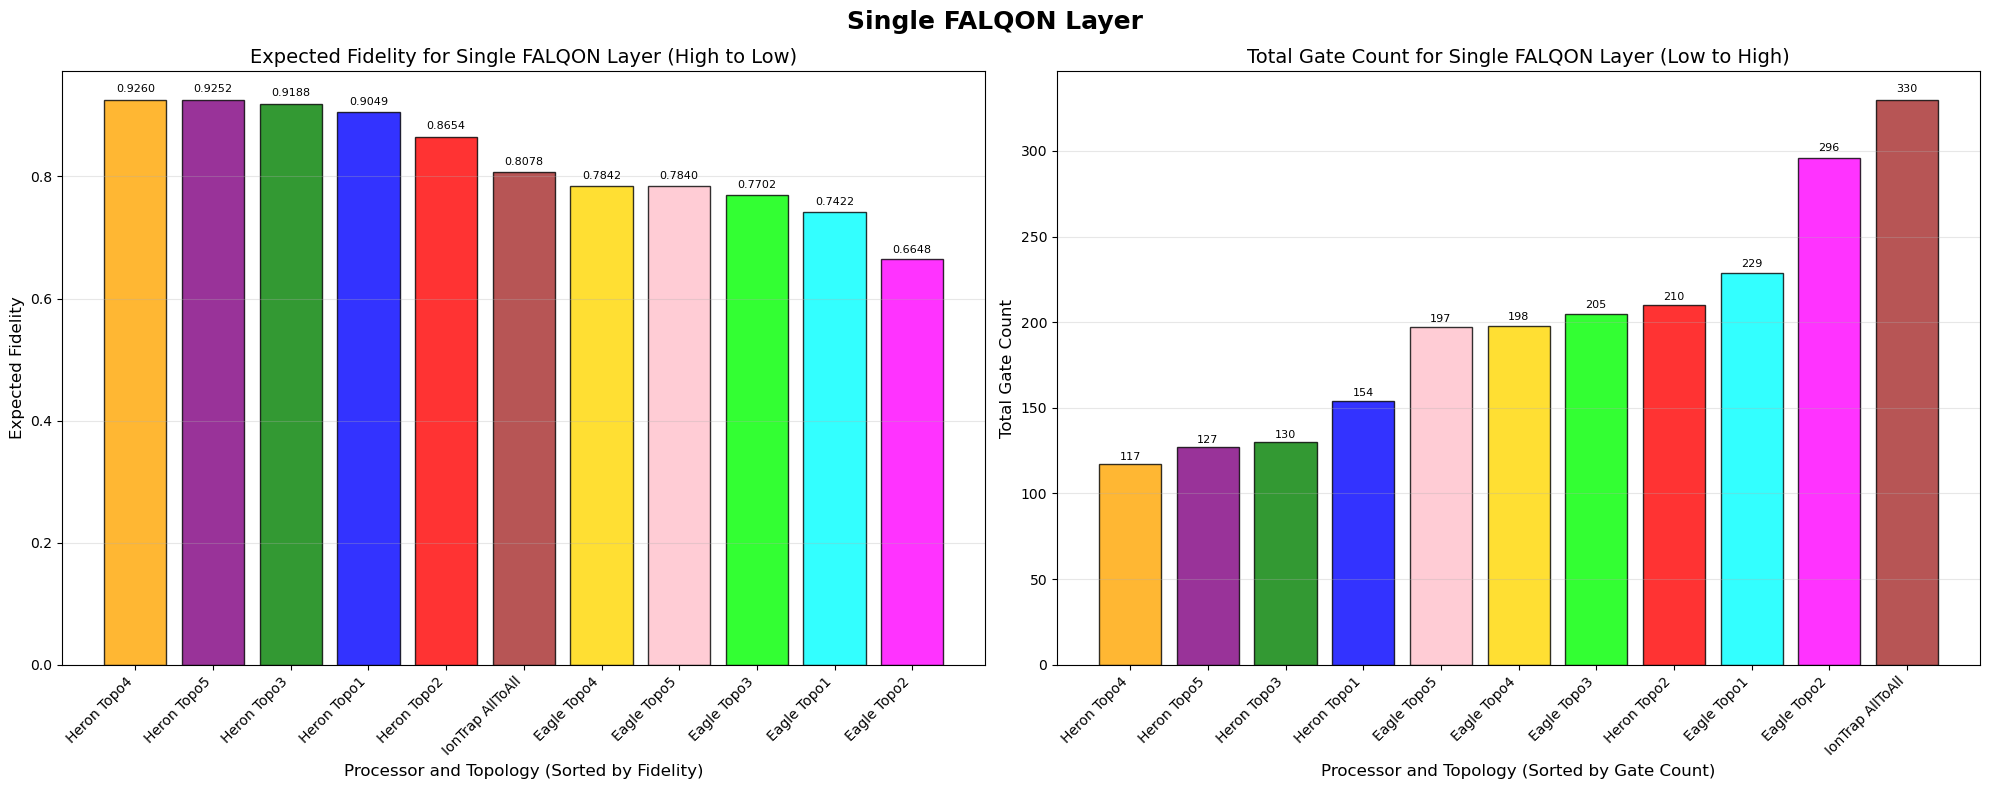


SINGLE FALQON LAYER - DETAILED RESULTS

RESULTS SORTED BY EXPECTED FIDELITY (High to Low):
Rank  Processor-Topology   Fidelity     Gate Count  
------------------------------------------------------------
1     Heron Topo4          0.925992     117         
2     Heron Topo5          0.925232     127         
3     Heron Topo3          0.918831     130         
4     Heron Topo1          0.904922     154         
5     Heron Topo2          0.865394     210         
6     IonTrap AllToAll     0.807835     330         
7     Eagle Topo4          0.784181     198         
8     Eagle Topo5          0.784004     197         
9     Eagle Topo3          0.770212     205         
10    Eagle Topo1          0.742181     229         
11    Eagle Topo2          0.664809     296         

RESULTS SORTED BY GATE COUNT (Low to High):
Rank  Processor-Topology   Gate Count   Fidelity    
------------------------------------------------------------
1     Heron Topo4          117          0.925992    

In [ ]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np

# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def single_falqon_step(qc, cost_h, driver_h, comm_h, delta_t, beta_0):
    """运行单个FALQON步骤"""
    state = Statevector.from_label("+" * n_qubits)
    
    # 单个FALQON层
    qc_layer = QuantumCircuit(n_qubits)
    falqon_layer(qc_layer, cost_h, driver_h, beta_0, delta_t)
    qc.compose(qc_layer, inplace=True)
    state = state.evolve(qc_layer)
    
    # 计算能量和下一个beta
    energy = state.expectation_value(cost_h).real
    next_beta = -1 * state.expectation_value(comm_h).real
    
    return qc, energy, next_beta

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
beta_0 = 0.0
delta_t = 0.03

# 处理器配置
processors = {
    "Heron": {
        "basis_gates": ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'],
        "gate_error": {
            "id": 2.738e-4,
            "rx": 2.738e-4,
            "rz": 0.0,
            "sx": 2.738e-4,
            "x": 2.738e-4,
            "cz": 1.947e-3,
            "rzz": 2.490e-3
        }
    },
    "Eagle": {
        "basis_gates": ['ecr', 'id', 'rz', 'sx', 'x'],
        "gate_error": {
            "ecr": 5.824e-3,      
            "id": 2.252e-4,      
            "rz": 0.0,           
            "sx": 2.252e-4,      
            "x": 2.252e-4,       
        }
    },
    "IonTrap": {
        "basis_gates": ["gpi", "gpi2", "zz"],
        "gate_error": {
            "gpi": 2e-4,
            "gpi2": 2e-4,
            "zz": 5.1e-3,
        }
    }
}

# 定义不同的拓扑结构
topologies = {
    "Topo1": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# Ion Trap 专用全连接拓扑
ion_trap_topology = {
    "AllToAll": CouplingMap.from_full(4)  # 全连接拓扑
}

# 存储所有结果
all_results = {}
labels = []

print("Testing single FALQON layer for Heron, Eagle, and Ion Trap Processors...")

# 对Heron和Eagle处理器的每个拓扑运行实验
for processor_name, processor_config in processors.items():
    if processor_name == "IonTrap":  # 跳过IonTrap，单独处理
        continue
        
    print(f"\n{'='*50}")
    print(f"Testing {processor_name} Processor")
    print(f"{'='*50}")
    
    basis_gates = processor_config["basis_gates"]
    gate_error = processor_config["gate_error"]
    
    for topo_name, coupling_list in topologies.items():
        combined_name = f"{processor_name} {topo_name}"
        labels.append(combined_name)
        print(f"\nTesting {combined_name}...")
        
        coupling_map = CouplingMap(couplinglist=coupling_list)
        
        # 初始化电路
        qc_initial = uniform_superposition_circuit()
        
        # 运行单个FALQON步骤
        final_circuit, energy, next_beta = single_falqon_step(
            qc=qc_initial,
            cost_h=cost_h,
            driver_h=driver_h,
            comm_h=comm_h,
            delta_t=delta_t,
            beta_0=beta_0
        )

        # Transpile 电路
        transpiled_circuit = transpile(
            final_circuit,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            optimization_level=1
        )

        # 统计 gate count
        gate_counts = transpiled_circuit.count_ops()
        total_count = sum(gate_counts.values())

        # 计算 expected fidelity
        expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
        
        # 存储结果
        all_results[combined_name] = {
            'fidelity': expected_fidelity,
            'gate_count': total_count,
            'energy': energy,
            'next_beta': next_beta,
            'processor': processor_name,
            'topology': topo_name
        }
        
        print(f"  Expected Fidelity: {expected_fidelity:.6f}")
        print(f"  Total Gate Count: {total_count}")
        print(f"  Energy: {energy:.6f}")

# 单独处理Ion Trap (All-to-All拓扑)
print(f"\n{'='*50}")
print(f"Testing IonTrap Processor")
print(f"{'='*50}")

processor_config = processors["IonTrap"]
basis_gates = processor_config["basis_gates"]
gate_error = processor_config["gate_error"]

combined_name = "IonTrap AllToAll"
labels.append(combined_name)
print(f"\nTesting {combined_name}...")

coupling_map = ion_trap_topology["AllToAll"]

# 初始化电路
qc_initial = uniform_superposition_circuit()

# 运行单个FALQON步骤
final_circuit, energy, next_beta = single_falqon_step(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0
)

# Transpile 电路
transpiled_circuit = transpile(
    final_circuit,
    basis_gates=basis_gates,
    coupling_map=coupling_map,
    optimization_level=1
)

# 统计 gate count
gate_counts = transpiled_circuit.count_ops()
total_count = sum(gate_counts.values())

# 计算 expected fidelity
expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)

# 存储结果
all_results[combined_name] = {
    'fidelity': expected_fidelity,
    'gate_count': total_count,
    'energy': energy,
    'next_beta': next_beta,
    'processor': "IonTrap",
    'topology': "AllToAll"
}

print(f"  Expected Fidelity: {expected_fidelity:.6f}")
print(f"  Total Gate Count: {total_count}")
print(f"  Energy: {energy:.6f}")

# 准备绘图数据并排序
# 创建包含所有信息的元组列表 (label, fidelity, gate_count, color_index)
plot_data = []
for i, label in enumerate(labels):
    plot_data.append((
        label, 
        all_results[label]['fidelity'], 
        all_results[label]['gate_count'],
        i  # 原始颜色索引
    ))

# 按保真度降序排序（高到低）
sorted_by_fidelity = sorted(plot_data, key=lambda x: x[1], reverse=True)

# 按门数升序排序（低到高）  
sorted_by_gate_count = sorted(plot_data, key=lambda x: x[2])

# 定义颜色 - 11种不同颜色
colors = ['blue', 'red', 'green', 'orange', 'purple', 
          'cyan', 'magenta', 'lime', 'gold', 'pink', 'brown']

# 创建柱状图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Single FALQON Layer', fontsize=18, fontweight='bold')

# 柱状图1: Expected Fidelity (按保真度从高到低排序)
fidelity_labels = [item[0] for item in sorted_by_fidelity]
fidelity_values = [item[1] for item in sorted_by_fidelity]
fidelity_colors = [colors[item[3]] for item in sorted_by_fidelity]

bars1 = ax1.bar(range(len(fidelity_labels)), fidelity_values, color=fidelity_colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_xlabel('Processor and Topology (Sorted by Fidelity)', fontsize=12)
ax1.set_ylabel('Expected Fidelity', fontsize=12)
ax1.set_title('Expected Fidelity for Single FALQON Layer (High to Low)', fontsize=14)
ax1.set_xticks(range(len(fidelity_labels)))
ax1.set_xticklabels(fidelity_labels, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 在柱子上方添加数值标签
for i, (bar, fidelity) in enumerate(zip(bars1, fidelity_values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{fidelity:.4f}', ha='center', va='bottom', fontsize=8, rotation=0)

# 柱状图2: Total Gate Count (按门数从低到高排序)
gate_labels = [item[0] for item in sorted_by_gate_count]
gate_values = [item[2] for item in sorted_by_gate_count]
gate_colors = [colors[item[3]] for item in sorted_by_gate_count]

bars2 = ax2.bar(range(len(gate_labels)), gate_values, color=gate_colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_xlabel('Processor and Topology (Sorted by Gate Count)', fontsize=12)
ax2.set_ylabel('Total Gate Count', fontsize=12)
ax2.set_title('Total Gate Count for Single FALQON Layer (Low to High)', fontsize=14)
ax2.set_xticks(range(len(gate_labels)))
ax2.set_xticklabels(gate_labels, rotation=45, ha='right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 在柱子上方添加数值标签
for i, (bar, count) in enumerate(zip(bars2, gate_values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

# 打印详细统计（按排序后的顺序）
print("\n" + "="*80)
print("SINGLE FALQON LAYER - DETAILED RESULTS")
print("="*80)

print("\nRESULTS SORTED BY EXPECTED FIDELITY (High to Low):")
print(f"{'Rank':<5} {'Processor-Topology':<20} {'Fidelity':<12} {'Gate Count':<12}")
print("-" * 60)
for i, (label, fidelity, gate_count, _) in enumerate(sorted_by_fidelity, 1):
    print(f"{i:<5} {label:<20} {fidelity:<12.6f} {gate_count:<12}")

print("\nRESULTS SORTED BY GATE COUNT (Low to High):")
print(f"{'Rank':<5} {'Processor-Topology':<20} {'Gate Count':<12} {'Fidelity':<12}")
print("-" * 60)
for i, (label, fidelity, gate_count, _) in enumerate(sorted_by_gate_count, 1):
    print(f"{i:<5} {label:<20} {gate_count:<12} {fidelity:<12.6f}")

# 找出最佳性能
print(f"\n{'='*80}")
print("PERFORMANCE ANALYSIS")
print("="*80)

best_fidelity = max(all_results.items(), key=lambda x: x[1]['fidelity'])
best_gate_count = min(all_results.items(), key=lambda x: x[1]['gate_count'])

print(f"Highest Fidelity: {best_fidelity[0]} with {best_fidelity[1]['fidelity']:.6f}")
print(f"Lowest Gate Count: {best_gate_count[0]} with {best_gate_count[1]['gate_count']} gates")

# 按处理器分组统计
print(f"\nHERON PROCESSOR AVERAGE:")
heron_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'Heron']
heron_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'Heron']
print(f"  Average Fidelity: {np.mean(heron_fidelities):.6f}")
print(f"  Average Gate Count: {np.mean(heron_gates):.1f}")

print(f"\nEAGLE PROCESSOR AVERAGE:")
eagle_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'Eagle']
eagle_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'Eagle']
print(f"  Average Fidelity: {np.mean(eagle_fidelities):.6f}")
print(f"  Average Gate Count: {np.mean(eagle_gates):.1f}")

print("\nION TRAP PROCESSOR AVERAGE:")
ion_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'IonTrap']
ion_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'IonTrap']
if ion_fidelities:  # 检查是否有IonTrap结果
    print(f"  Average Fidelity: {np.mean(ion_fidelities):.6f}")
    print(f"  Average Gate Count: {np.mean(ion_gates):.1f}")

In [17]:
import numpy as np
from qiskit.circuit import Gate, QuantumCircuit, Parameter
from qiskit.circuit.library import RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, CXGate, SwapGate, RZZGate
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider
# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

# 处理器配置
processors = {
    "Heron": {
        "basis_gates": ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'],
        "gate_error": {
            "id": 2.738e-4,
            "rx": 2.738e-4,
            "rz": 0.0,
            "sx": 2.738e-4,
            "x": 2.738e-4,
            "cz": 1.947e-3,
            "rzz": 2.490e-3
        }
    },
    "Eagle": {
        "basis_gates": ['ecr', 'id', 'rz', 'sx', 'x'],
        "gate_error": {
            "ecr": 5.824e-3,      
            "id": 2.252e-4,      
            "rz": 0.0,           
            "sx": 2.252e-4,      
            "x": 2.252e-4,       
        }
    },
    "IonTrap": {
        "basis_gates": ["gpi", "gpi2", "zz"],
        "gate_error": {
            "gpi": 2e-4,
            "gpi2": 2e-4,
            "zz": 5.1e-3,
        }
    }
}

# 定义不同的拓扑结构
topologies = {
    "Topo1": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# Ion Trap 专用全连接拓扑
ion_trap_topology = CouplingMap.from_full(4)

# 生成精度阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)

# 存储所有结果
all_results = {}

print("Testing different topologies for Heron, Eagle, and Ion Trap Processors...")

# 对Heron和Eagle处理器的每个拓扑运行实验
for processor_name, processor_config in processors.items():
    if processor_name == "IonTrap":  # 跳过IonTrap，单独处理
        continue
        
    print(f"\n{'='*50}")
    print(f"Testing {processor_name} Processor")
    print(f"{'='*50}")
    
    basis_gates = processor_config["basis_gates"]
    gate_error = processor_config["gate_error"]
    
    print("Gate median errors:")
    for gate, error in gate_error.items():
        print(f"  {gate}: {error}")
    
    for topo_name, coupling_list in topologies.items():
        combined_name = f"{processor_name} - {topo_name}"
        print(f"\nTesting {combined_name}...")
        
        coupling_map = CouplingMap(couplinglist=coupling_list)
        fidelity_list = []
        total_count_list = []
        
        for threshold in precision_list:
            # 初始化电路
            qc_initial = uniform_superposition_circuit()
            
            # 运行 main_loop
            beta_list, energy_list, final_circuit = main_loop_2(
                qc=qc_initial,
                cost_h=cost_h,
                driver_h=driver_h,
                comm_h=comm_h,
                delta_t=delta_t,
                beta_0=beta_0,
                n_steps=n_steps,
                diff_threshold=threshold
            )

            # Transpile 电路
            transpiled_circuit = transpile(
                final_circuit,
                basis_gates=basis_gates,
                coupling_map=coupling_map,
                optimization_level=1
            )

            # 统计 gate count
            gate_counts = transpiled_circuit.count_ops()
            total_count = sum(gate_counts.values())
            total_count_list.append(total_count)

            # 计算 expected fidelity
            expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
            fidelity_list.append(expected_fidelity)
            
            # 如果保真度太低就提前退出
            if expected_fidelity < 0.0001:
                print(f"Expected fidelity reached threshold for {combined_name}, stopping early.")
                break
        
        # 存储结果
        all_results[combined_name] = {
            'precision': precision_list[:len(fidelity_list)],
            'fidelity': fidelity_list,
            'gate_count': total_count_list,
            'processor': processor_name,
            'topology': topo_name
        }
        
        print(f"{combined_name} completed with {len(fidelity_list)} data points")

# 单独处理Ion Trap (All-to-All拓扑)
print(f"\n{'='*50}")
print(f"Testing IonTrap Processor")
print(f"{'='*50}")

processor_config = processors["IonTrap"]
basis_gates = processor_config["basis_gates"]
gate_error = processor_config["gate_error"]

print("Gate median errors:")
for gate, error in gate_error.items():
    print(f"  {gate}: {error}")

combined_name = "IonTrap - AllToAll"
print(f"\nTesting {combined_name}...")

fidelity_list = []
total_count_list = []

for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    beta_list, energy_list, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates,
        coupling_map=ion_trap_topology,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()
    total_count = sum(gate_counts.values())
    total_count_list.append(total_count)

    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    
    # 如果保真度太低就提前退出
    if expected_fidelity < 0.0001:
        print(f"Expected fidelity reached threshold for {combined_name}, stopping early.")
        break

# 存储Ion Trap结果
all_results[combined_name] = {
    'precision': precision_list[:len(fidelity_list)],
    'fidelity': fidelity_list,
    'gate_count': total_count_list,
    'processor': "IonTrap",
    'topology': "AllToAll"
}

print(f"{combined_name} completed with {len(fidelity_list)} data points")

# 绘制合并图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparison: Heron vs Eagle vs Ion Trap Processors', fontsize=18, fontweight='bold')

# 定义颜色和线型
heron_colors = ['blue', 'red', 'green', 'orange', 'purple']
eagle_colors = ['cyan', 'magenta', 'lime', 'gold', 'pink']
ion_trap_color = 'brown'
heron_linestyle = '-'
eagle_linestyle = '--'
ion_trap_linestyle = ':'

# Plot 1: Precision vs Expected Fidelity
heron_results = []
eagle_results = []

for i, (combined_name, results) in enumerate(all_results.items()):
    if results['processor'] == 'Heron':
        color = heron_colors[len(heron_results)]
        linestyle = heron_linestyle
        heron_results.append(combined_name)
    elif results['processor'] == 'Eagle':
        color = eagle_colors[len(eagle_results)]
        linestyle = eagle_linestyle
        eagle_results.append(combined_name)
    else:  # IonTrap
        color = ion_trap_color
        linestyle = ion_trap_linestyle
    
    ax1.plot(results['precision'], results['fidelity'], 
             marker='o', label=combined_name, color=color, linestyle=linestyle, linewidth=2, markersize=4)

ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)', fontsize=12)
ax1.set_ylabel('Expected Fidelity', fontsize=12)
ax1.set_title('Precision vs Expected Fidelity', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Plot 2: Precision vs Total Basis Count
for i, (combined_name, results) in enumerate(all_results.items()):
    if results['processor'] == 'Heron':
        color = heron_colors[heron_results.index(combined_name)]
        linestyle = heron_linestyle
    elif results['processor'] == 'Eagle':
        color = eagle_colors[eagle_results.index(combined_name)]
        linestyle = eagle_linestyle
    else:  # IonTrap
        color = ion_trap_color
        linestyle = ion_trap_linestyle
    
    ax2.plot(results['precision'], results['gate_count'], 
             marker='o', label=combined_name, color=color, linestyle=linestyle, linewidth=2, markersize=4)

ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)', fontsize=12)
ax2.set_ylabel('Total Basis Count', fontsize=12)
ax2.set_title('Precision vs Total Basis Count', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# 打印汇总统计
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY STATISTICS")
print("="*80)

print("\nHERON PROCESSOR RESULTS:")
print("-" * 40)
for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        max_fidelity = max(results['fidelity'])
        min_gate_count = min(results['gate_count'])
        print(f"{results['topology']}:")
        print(f"  Maximum Fidelity: {max_fidelity:.6f}")
        print(f"  Minimum Gate Count: {min_gate_count}")
        print(f"  Data Points: {len(results['fidelity'])}")

print("\nEAGLE PROCESSOR RESULTS:")
print("-" * 40)
for combined_name, results in all_results.items():
    if results['processor'] == 'Eagle':
        max_fidelity = max(results['fidelity'])
        min_gate_count = min(results['gate_count'])
        print(f"{results['topology']}:")
        print(f"  Maximum Fidelity: {max_fidelity:.6f}")
        print(f"  Minimum Gate Count: {min_gate_count}")
        print(f"  Data Points: {len(results['fidelity'])}")

print("\nION TRAP PROCESSOR RESULTS:")
print("-" * 40)
for combined_name, results in all_results.items():
    if results['processor'] == 'IonTrap':
        max_fidelity = max(results['fidelity'])
        min_gate_count = min(results['gate_count'])
        print(f"{results['topology']}:")
        print(f"  Maximum Fidelity: {max_fidelity:.6f}")
        print(f"  Minimum Gate Count: {min_gate_count}")
        print(f"  Data Points: {len(results['fidelity'])}")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("• Heron processor uses solid lines (-), Eagle processor uses dashed lines (--), Ion Trap uses dotted lines (:)")
print("• Heron basis gates: ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']")
print("• Eagle basis gates: ['ecr', 'id', 'rz', 'sx', 'x']")
print("• Ion Trap basis gates: ['gpi', 'gpi2', 'zz']")
print("• Ion Trap has all-to-all connectivity advantage")
print("• Different processors show varying performance trade-offs across precision levels")

Testing different topologies for Heron, Eagle, and Ion Trap Processors...

Testing Heron Processor
Gate median errors:
  id: 0.0002738
  rx: 0.0002738
  rz: 0.0
  sx: 0.0002738
  x: 0.0002738
  cz: 0.001947
  rzz: 0.00249

Testing Heron - Topo1...
Expected fidelity reached threshold for Heron - Topo1, stopping early.
Heron - Topo1 completed with 5 data points

Testing Heron - Topo2...
Expected fidelity reached threshold for Heron - Topo2, stopping early.
Heron - Topo2 completed with 2 data points

Testing Heron - Topo3...
Expected fidelity reached threshold for Heron - Topo3, stopping early.
Heron - Topo3 completed with 10 data points

Testing Heron - Topo4...
Expected fidelity reached threshold for Heron - Topo4, stopping early.
Heron - Topo4 completed with 10 data points

Testing Heron - Topo5...
Expected fidelity reached threshold for Heron - Topo5, stopping early.
Heron - Topo5 completed with 7 data points

Testing Eagle Processor
Gate median errors:
  ecr: 0.005824
  id: 0.0002252

TranspilerError: "Unable to translate the operations in the circuit: ['rzz', 'sdg', 'h', 'cx', 's', 'rz', 'rx'] to the backend's (or manually specified) target basis: ['while_loop', 'store', 'zz', 'reset', 'for_loop', 'delay', 'gpi', 'measure', 'barrier', 'switch_case', 'gpi2', 'snapshot', 'if_else']. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.BasisTranslator#translation-errors"

NameError: name 'all_results' is not defined

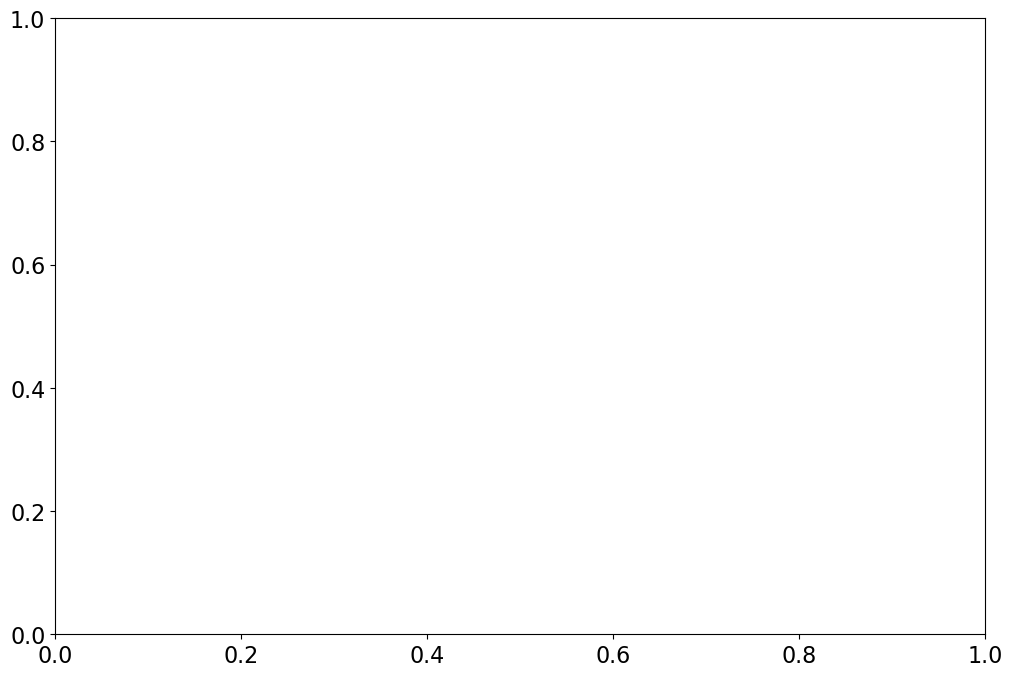

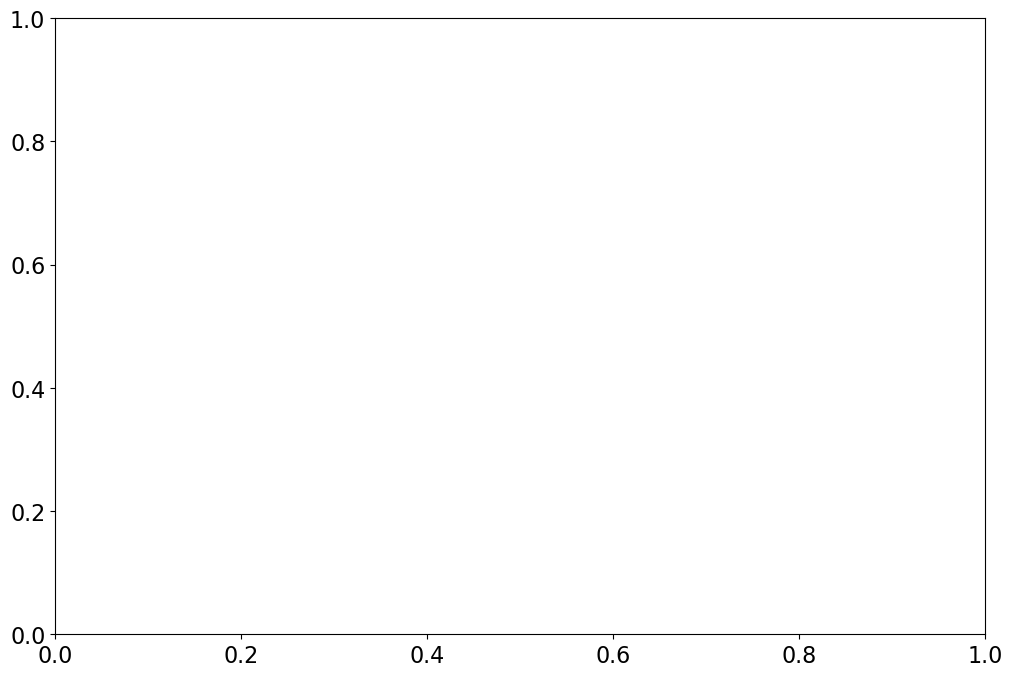

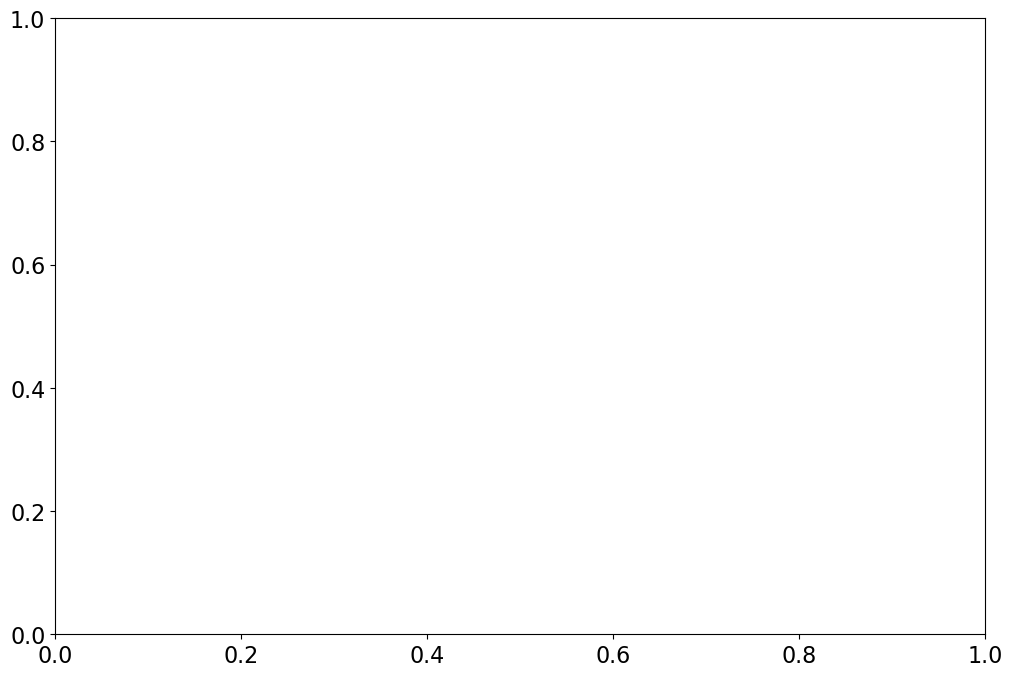

In [ ]:
# 改进的绘图代码 - 支持Heron, Eagle, IonTrap三种处理器
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# 设置更大的字体
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'legend.fontsize': 14,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
})

# 防色盲的颜色和标记样式
heron_styles = [
    {'color': '#1f77b4', 'marker': 'o', 'linestyle': '-'},      # 蓝色，圆圈
    {'color': '#ff7f0e', 'marker': 's', 'linestyle': '-'},      # 橙色，方块
    {'color': '#2ca02c', 'marker': '^', 'linestyle': '-'},      # 绿色，三角形
    {'color': '#d62728', 'marker': 'D', 'linestyle': '-'},      # 红色，菱形
    {'color': '#9467bd', 'marker': 'v', 'linestyle': '-'}       # 紫色，倒三角形
]

eagle_styles = [
    {'color': '#17becf', 'marker': 'p', 'linestyle': '-'},      # 青色，五角星
    {'color': '#bcbd22', 'marker': 'h', 'linestyle': '-'},      # 橄榄色，六边形
    {'color': '#e377c2', 'marker': '*', 'linestyle': '-'},      # 粉色，星号
    {'color': '#8c564b', 'marker': 'X', 'linestyle': '-'},      # 棕色，X形
    {'color': '#7f7f7f', 'marker': '+', 'linestyle': '-'}       # 灰色，加号
]

# IonTrap专用样式
iontrap_style = {'color': '#ff1493', 'marker': '8', 'linestyle': '-'}  # 深粉色，八边形

# 创建三个独立的图
fig1, ax1 = plt.subplots(figsize=(12, 8))
fig2, ax2 = plt.subplots(figsize=(12, 8))
fig3, ax3 = plt.subplots(figsize=(12, 8))

# 绘制第一个图：Precision vs Expected Fidelity
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    elif results['processor'] == 'Eagle':
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    else:  # IonTrap
        style = iontrap_style
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 5
        markersize = 14
        markeredgewidth = 3.5
    else:
        linewidth = 3
        markersize = 10
        markeredgewidth = 2.5
    
    ax1.plot(results['precision'], results['fidelity'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name, 
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.8)

ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)', fontweight='bold')
ax1.set_ylabel('Expected Fidelity', fontweight='bold')
ax1.set_title('Precision vs Expected Fidelity\n(Heron, Eagle, IonTrap: Different Colors and Shapes)', 
              fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, linewidth=1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 绘制第二个图：Precision vs Total Basis Count
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    elif results['processor'] == 'Eagle':
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    else:  # IonTrap
        style = iontrap_style
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 5
        markersize = 14
        markeredgewidth = 3.5
    else:
        linewidth = 3
        markersize = 10
        markeredgewidth = 2.5
    
    ax2.plot(results['precision'], results['gate_count'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name,
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.8)

ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)', fontweight='bold')
ax2.set_ylabel('Total Basis Count', fontweight='bold')
ax2.set_title('Precision vs Total Basis Count\n(Heron, Eagle, IonTrap: Different Colors and Shapes)', 
              fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3, linewidth=1)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 创建第三个图：放大拥挤区域
heron_count = 0
eagle_count = 0

for combined_name, results in all_results.items():
    if results['processor'] == 'Heron':
        style = heron_styles[heron_count % len(heron_styles)]
        heron_count += 1
    elif results['processor'] == 'Eagle':
        style = eagle_styles[eagle_count % len(eagle_styles)]
        eagle_count += 1
    else:  # IonTrap
        style = iontrap_style
    
    # 为Topo3设置更粗的线条和更大的标记
    if 'Topo3' in combined_name:
        linewidth = 6
        markersize = 16
        markeredgewidth = 4
    else:
        linewidth = 4
        markersize = 12
        markeredgewidth = 3
    
    ax3.plot(results['precision'], results['fidelity'], 
             color=style['color'], marker=style['marker'], 
             linestyle=style['linestyle'], linewidth=linewidth, 
             markersize=markersize, label=combined_name, 
             markeredgewidth=markeredgewidth, markeredgecolor='white',
             zorder=5, alpha=0.9, markevery=1)

# 设置放大区域的范围 - 专注在0.2附近的x值和0以上的y值
ax3.set_xlim(0.18, 0.22)  # 专注在0.2这个区域
ax3.set_ylim(0.0, 0.0003)  # 只关心0以上的值

ax3.set_xscale('log')
ax3.set_xlabel('Precision (diff_to_target)', fontweight='bold')
ax3.set_ylabel('Expected Fidelity', fontweight='bold')
ax3.set_title('Zoomed View: Precision vs Expected Fidelity (Near-Zero Region)\n(Heron, Eagle, IonTrap: Different Colors and Shapes)', 
              fontweight='bold', pad=20)
ax3.grid(True, alpha=0.3, linewidth=1)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整布局并显示
plt.figure(fig1.number)
plt.tight_layout()
plt.figure(fig2.number)
plt.tight_layout()
plt.figure(fig3.number)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from qiskit.circuit import Gate, QuantumCircuit, Parameter
from qiskit.circuit.library import RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, CXGate, SwapGate, RZZGate
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider



Gate median errors (percentage):
gpi: 0.0002%
gpi2: 0.0002%
zz: 0.0051%


TranspilerError: "Unable to translate the operations in the circuit: ['rzz', 'sdg', 'h', 'cx', 's', 'rz', 'rx'] to the backend's (or manually specified) target basis: ['while_loop', 'store', 'zz', 'reset', 'for_loop', 'delay', 'gpi', 'measure', 'barrier', 'switch_case', 'gpi2', 'snapshot', 'if_else']. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.BasisTranslator#translation-errors"

In [ ]:
import numpy as np
from qiskit.circuit import Gate, QuantumCircuit, Parameter
from qiskit.circuit.library import RZGate, XGate, RXGate, RYGate, HGate, SGate, SdgGate, CXGate, SwapGate, RZZGate
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap

from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider

qc_abstract = QuantumCircuit(2, 2, name="hello world, native gates")
qc_abstract.h(0)
qc_abstract.cx(0, 1)

qc_abstract.draw()

provider = IonQProvider()
backend_native = provider.get_backend("simulator", gateset="native")

transpiled_circuit = transpile(qc_abstract, backend=backend_native)

for gate, count in transpiled_circuit.count_ops().items():
    print(f"{gate}: {count}")


gpi2: 6
gpi: 1
ms: 1


/tmp/ipykernel_105095/2893641440.py:39: DeprecationWarning: The `transpile` function will stop supporting inputs of type `BackendV1` ( ionq_simulator ) in the `backend` parameter in a future release no earlier than 2.0. `BackendV1` is deprecated and implementations should move to `BackendV2`.
  transpiled_circuit = transpile(qc_abstract, backend=backend_native)
